#Toxic Comment Classification (Kaggle) - Simple Baseline

Simple baseline model for the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/rules) that uses Glove embeddings and a bidirectional GRU with Tensorflow 2.0

Likely ways to further improve the model:


*   Use an embedding method that takes into account the context of the sentence e.g. BERT
*   Use optimisation tricks like a circular learning rate schedule
*   Try using an attention-based architecture
*   Try different forms of pre-processing, e.g. removing stop words like "the"
*   Increase the allowed max length of sequence



 

In [0]:
!pip install tensorflow==2.0 -q
!pip install tensorflow-gpu==2.0 -q

     |████████████████████████████████| 86.3MB 69.6MB/s 
     |████████████████████████████████| 3.8MB 30.3MB/s 
     |████████████████████████████████| 450kB 43.9MB/s 
     |████████████████████████████████| 380.8MB 124kB/s 


In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from google.colab import drive 
from sklearn.model_selection import train_test_split

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

drive.mount('/content/drive')

Mounted at /content/drive


#1. Download and Prepare the Data

In [0]:
#Download the data
#Replace these lines with paths to the data for the competition which can be found here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
DRIVE_FOLDER = '/content/drive/My Drive/Toxic_Comment_Classification_Kaggle/'
train = pd.read_csv(DRIVE_FOLDER + 'train.csv')
test = pd.read_csv(DRIVE_FOLDER + 'test.csv')
print("Loaded training data, shape: ", train.shape)
print("Loaded test data, shape: ", test.shape)
print(train.head().to_string())

#Check for null values
print(train.isnull().any())
print(test.isnull().any())

#Split into features and dependent variables 
train_X = train["comment_text"].values
test_X = test["comment_text"].values
train_y = train.iloc[:, 2:].values

Loaded training data, shape:  (159571, 8)
Loaded test data, shape:  (153164, 2)
                 id                                       comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0             0        0       0       0              0
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0             0        0       0       0              0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0             0        0       0       0              0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0             0        0       0       0              0
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0             0        0       0       0              0
id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat       

In [0]:
from keras.preprocessing import text, sequence
max_num_words = 30000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(list(train_X) + list(test_X) )

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

Using TensorFlow backend.


Now we explore the distribution of sentence lengths so we can understand what max sentence length to set and therefore how much padding to do

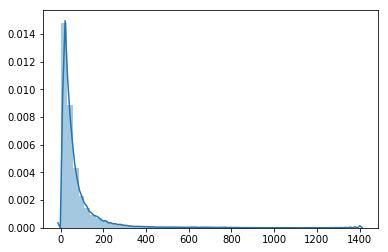

In [0]:
import seaborn as sns
sentence_lengths = [len(sentence) for sentence in train_X]
sns.distplot(sentence_lengths);

max_length = 400
train_X = sequence.pad_sequences(train_X, maxlen=max_length)
test_X = sequence.pad_sequences(test_X, maxlen=max_length)

Now we load a dictionary containing Glove embeddings of the form: {word: embedding}.  Then we create an embedding matrix that maps the words in our vocabulary to their embeddings.

In [0]:
#Replace this line with a path to the glove embeddings file which you can download here: https://www.kaggle.com/watts2/glove6b50dtxt
EMBEDDING_FILE = DRIVE_FOLDER + 'glove.6B.50d.txt'   

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
max_number_words = 30000
embedding_dimension = 50
number_words = min(max_number_words, len(word_index))
embedding_matrix = np.zeros((number_words, embedding_dimension))
for word, i in word_index.items():
    if i >= max_number_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

#2. Modelling

First we create our model object

In [0]:
from tensorflow.keras import Model, activations
from tensorflow.keras.layers import Dense, Concatenate, GRU, LSTM, SpatialDropout1D, \
Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Embedding

gru_hidden_size = 40
dropout_rate = 0.1

class gru_model(Model):

  def __init__(self):
    Model.__init__(self)
    self.gru = Bidirectional(GRU(units=gru_hidden_size, return_sequences=True))
    #We use spatial dropout instead of dropout because the different dimensions of an embedding are likely to be highly correlated and so it is a more effective method of regularisation to drop whole embedding
    #vectors at a time rather than only dropping parts of embedding vectors
    self.spatial_dropout = SpatialDropout1D(dropout_rate) 
    self.global_avg_pooling = GlobalAveragePooling1D()
    self.global_max_pooling = GlobalMaxPooling1D()
    self.embedding = Embedding(max_number_words, embedding_dimension, input_length=max_length, weights=[embedding_matrix])
    self.fc_layer = Dense(6, activation="sigmoid")
  
  def call(self, x, training=True):
    """Forward pass for the network. Note that it expects input data in the form (batch, seq length, features)"""
    x = self.embedding(x)
    if training:
      x = self.spatial_dropout(x)
    x = self.gru(x)
    avg_pool = self.global_avg_pooling(x)
    max_pool = self.global_max_pooling(x)
    x = Concatenate(axis=1)([avg_pool, max_pool])
    x = self.fc_layer(x)
    return x

Then we create a ROC-AUC evaluation callback because it is this crtieria that the Kaggle competition is judged on

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
                                          
class ROCAUCEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

Then we compile and train the model

In [0]:
batch_size = 32
epochs = 1
model = gru_model()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])                            
tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, train_size=0.95, random_state=SEED)
rocauc = ROCAUCEvaluation(validation_data=(val_X, val_y), interval=1)
hist = model.fit(tr_X, tr_y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_y), callbacks=[rocauc]) 

Train on 151592 samples, validate on 7979 samples
151584/151592 [============================>.] - ETA: 0s - loss: 0.0334 - accuracy: 0.9869
 ROC-AUC - epoch: 1 - score: 0.987150 

151592/151592 [==============================] - 668s 4ms/sample - loss: 0.0334 - accuracy: 0.9869 - val_loss: 0.0410 - val_accuracy: 0.9848


**Our validation set ROC-AUC is 0.987. A similar score on the test set would put us in the top 1% of Kaggle submissions as of 9/10/19**

In [0]:
#How to create a submission csv file for Kaggle
submission = pd.read_csv(DRIVE_FOLDER + "sample_submission.csv")
y_pred = model.predict(test_X, batch_size=1024)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)